# MCMC CALIBRATION TECHNICS IN CONTEXT OF  INFECTIOUS DISEASE MODELING

## Prerequies

In [ ]:
# pip install multiprocess
# %pip install --upgrade --force-reinstall multiprocess

#Compatible with latest jax version  
# %pip install summerepi2==1.3.6
# %pip install jinja2

In [ ]:
import multiprocess as mp
import platform

# This is required for pymc parallel evaluation in notebooks 
# But has to be change while using a python script 
# Use this following instruction instead
# if __name__ == "__main__":
#     if platform.system() != "Windows":
#         mp.set_start_method('spawn')
    
    # rest of your code body here inside the if __name__
if platform.system() != "Windows":
    
    mp.set_start_method('forkserver')

In [ ]:
import Calibrate as cal #Runing the calibration process and gathering results
from calibs_utilities import get_all_priors, get_targets, load_data
from models.models import model1, model2 #All the models we design for the test
from Calibrate import plot_comparison_bars

# Combining tagets and prior with our summer2 model in a BayesianCompartmentalModel (bcm_model_1)
from estival.model import BayesianCompartmentalModel
from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling.tools import likelihood_extras_for_samples


import pandas as pd
import numpy as np
# import plotly.express as px
import matplotlib.pyplot as plt
from typing import List

import pymc as pm

# We use estivals parallel tools to run the model evaluations
from estival.utils.parallel import map_parallel

# import numpyro
# from numpyro import distributions as dist
from numpyro import infer
import arviz as az
import pickle
from datetime import datetime
from plotly import graph_objects as go
# import jax
from jax import numpy as jnp
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting


# Application 1: The basic SIR model

## Calibration Data
If data are needed to define a target, we just need to import it from our file data which we will design correctly.
In this example we import data from a YAML file.

In [ ]:
#An example of data for the calibration 

output_labels = {"index": "time", "value": "number infectious"}

targets_yml = './data/target_yml.yml'
targets = load_data(targets_yml)
targets_data = targets['active_cases']

# targets_data.plot(kind="scatter",labels=output_labels)



In [ ]:
#Names of parameters and their ranges
params = {
    "contact_rate": (0.0,1.0),
    "recovery_rate": (0.0,1.0)

}
targets = get_targets(targets_yml)
priors = get_all_priors(params)

## Model Definition and Configuration

A mechanistic model (ODE-Based) model discribing Infectious Disease transmission.

In [ ]:
model_1 = model1() 

### Trial run 

In [ ]:
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting

parameters = {
    "contact_rate": 0.2,
    "recovery_rate": 0.1,
    #"active_cases_dispersion": 0.5,
}

model_1.run(parameters)
#plt.rcParams["figure.figsize"] = (5, 5)


df = pd.DataFrame(
    {
        "modelled": model_1.get_outputs_df()["I"],
        "observed": targets_data,
    }
)
df.plot(kind="scatter", labels=output_labels) #,figsize=(3,3));

### Sampling 

In [ ]:
#Defining  a Bayesian Compartmental Model

bcm_model_1 = BayesianCompartmentalModel(model_1, parameters, priors, targets)
bcm_model_1.targets["active_cases"]


In [ ]:
##____Uniform Initialisation_________
init_vals = []
for c in range(4):
    init_vals.append({param: np.random.uniform(0.0,1.0) for param in parameters.keys()})

 
init_vals

init_vals_nuts = {param: jnp.array(np.random.uniform(0.0,1.0, 4)) for param in parameters.keys()}


#### Simple Run

In [ ]:
%%time
D = 2 # Dimension of the parameter's space
samplers = [pm.sample_smc] + [infer.NUTS]*2 + [pm.DEMetropolisZ]*2 + [pm.DEMetropolis]*2 + [pm.Metropolis]*4
Draws = [2000] + [2000]*2 + [4000]*6 + [8000]*2
Tunes = [0] + [100, 1000]*5
chains = 2*D
results_df = pd.DataFrame()

for sampler, draws, tune in zip (samplers, Draws, Tunes):
    if sampler.__name__ == "NUTS":
        init = init_vals_nuts
    else:
        init = init_vals
    results = cal.multirun(sampler = sampler, 
            draws = draws,
            chains=chains,
            cores = chains,
            tune = tune,
            bcm_model = bcm_model_1,
            n_iterations = 1,
            n_jobs = 1,
            initial_params = init

    )
            
    results_df = pd.concat([results_df,results])



results_df = results_df.reset_index(drop=True)


In [ ]:
results_df

In [35]:
results_df.style.set_caption("MCMC COMPARISON") 

#Storing results on a pickle file
# with open('./Results/Model_1/Simple_run_results_2.pkl', 'wb') as fp:
#     pickle.dump(results_df, fp)


# #Loading a pickle file
# with open('./Results/Model_1/Simple_run_results.pkl', 'rb') as fp:
#     res = pickle.load(fp)

,Sampler,Draws,Chains,Tune,Time,Mean_ESS,Min_Ess,Ess_per_sec,Mean_Rhat,Rhat_max,Trace,Run
0,sample_smc,2000,4,0,13.005662,59.675913,31.681385,4.588457,1.071367,1.081730,Inference data with groups: > posterior > sample_stats,sample_smc Draws=2000 Tune=0
1,NUTS,2000,4,100,31.524645,1140.985578,1134.640436,36.193447,1.003326,1.003330,Inference data with groups: > posterior > log_likelihood > sample_stats > observed_data,NUTS Draws=2000 Tune=100
2,NUTS,2000,4,1000,33.486870,1348.920851,1336.663197,40.282083,1.004022,1.004511,Inference data with groups: > posterior > log_likelihood > sample_stats > observed_data,NUTS Draws=2000 Tune=1000
3,DEMetropolisZ,4000,4,100,27.572801,41.852000,38.791414,1.517873,1.064401,1.067646,Inference data with groups: > posterior > sample_stats,DEMetropolisZ Draws=4000 Tune=100
4,DEMetropolisZ,4000,4,1000,23.719712,2062.357275,2014.157163,86.946976,1.002529,1.002771,Inference data with groups: > posterior > sample_stats,DEMetropolisZ Draws=4000 Tune=1000
5,DEMetropolis,4000,4,100,22.462599,4.760280,4.671975,0.211920,2.602557,2.729054,Inference data with groups: > posterior > sample_stats,DEMetropolis Draws=4000 Tune=100
6,DEMetropolis,4000,4,1000,23.286239,1208.920465,1191.146933,51.915661,1.004659,1.005069,Inference data with groups: > posterior > sample_stats,DEMetropolis Draws=4000 Tune=1000
7,Metropolis,4000,4,100,24.419664,4.928864,4.917964,0.201840,2.347803,2.356810,Inference data with groups: > posterior > sample_stats,Metropolis Draws=4000 Tune=100
8,Metropolis,4000,4,1000,25.436725,8.011946,7.939630,0.314976,1.433841,1.440277,Inference data with groups: > posterior > sample_stats,Metropolis Draws=4000 Tune=1000
9,Metropolis,8000,4,100,29.621529,4.905816,4.904458,0.165617,2.375201,2.375917,Inference data with groups: > posterior > sample_stats,Metropolis Draws=8000 Tune=100


In [ ]:
#Loading a pickle file
with open('./Results/Model_1/Simple_run_results.pkl', 'rb') as fp:
    res = pickle.load(fp)

In [ ]:
def group_summary(results_df):
    s = []
    for row in results_df.index:
        truncated_trace = results_df.Trace.loc[row].posterior
        summary = az.summary(truncated_trace)
        summary["Sampler"] = results_df.at[row, "Sampler"]
        s.append(summary)
    summaries = pd.concat(s)

    summaries["Variables"] = summaries.index
    summaries.set_index("Sampler", inplace=True)

    sum_dict = dict()
    summary_means = pd.DataFrame()

    for sampler in ["sample_smc","NUTS", "DEMetropolis", "DEMetropolisZ", "Metropolis"]:
        sum_dict[sampler] = summaries.loc[sampler].groupby("Variables").mean().reset_index(drop=False)

    summary_means = pd.concat(sum_dict)
    #computing the pecentage of Mean rhat <= 1.01
    prcnt_success= pd.DataFrame()
    prcnt_success["Mean rhat <= 1.01(%)"] = results_df.groupby('Sampler')['Mean_Rhat'].apply(lambda x: (x <= 1.01).mean() * 100)

    return summary_means, prcnt_success

In [ ]:
summaries_mean, prcnt_succ = group_summary(results_df)

In [ ]:
summaries_mean

In [34]:
prcnt_succ

,Mean rhat <= 1.01(%)
Sampler,
DEMetropolis,50.0
DEMetropolisZ,50.0
Metropolis,0.0
NUTS,100.0
sample_smc,0.0


In [ ]:
AllTrace = res["Trace"]

In [ ]:
az.summary(AllTrace[6])

In [ ]:
cols = res.columns
res[cols[~cols.isin(["Trace", "Run"])]].round(2).style.set_caption(
    "Results of MCMC Sampling of 10-Dimensional Target Distribution"
)

In [ ]:
# plot_comparison_Bars(results_df=res)
plot_comparison_bars(results_df.round(2))

### Multiple runs

In [ ]:
all_results = dict()

In [ ]:
sampler = infer.NUTS
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 2000,
    tune = 1000,
    chains=4,
    cores=4, 
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 2,
    initial_params = init_vals_nuts
    )

In [ ]:
df = pd.concat(all_results)
df["Trace"]

In [42]:
summaries_mean, prcnt_succ = group_summary(df)

In [44]:
prcnt_succ

,Mean rhat <= 1.01(%)
Sampler,
DEMetropolis,40.0
DEMetropolisZ,95.0
Metropolis,0.0
NUTS,100.0
sample_smc,37.0


In [ ]:
sampler = pm.DEMetropolis
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 8000,
    tune = 1000,
    chains=4,
    cores=4, 
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 2,
    initial_params = init_vals
    )

In [ ]:
sampler = pm.DEMetropolisZ
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 8000,
    chains=4,
    cores=4,
    tune = 1000, 
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 2,
    initial_params = init_vals
    )

In [ ]:
sampler = pm.Metropolis
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 8000,
    tune = 1000, 
    chains=4,
    cores=4,
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 2,
    initial_params = init_vals
    )

In [ ]:
sampler = pm.sample_smc
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 2000,
    tune = 0,
    chains=4,
    cores=4, 
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 2,
    initial_params = None
    )

In [75]:
import pymc as pm
from estival.wrappers import pymc as epm
with pm.Model() as model:
    variables = epm.use_model(bcm_model_1)
    idata_smc = pm.sample_smc(kernel=pm.smc.IMH, compute_convergence_checks=False, start = None, draws=15000,chains=4, threshold = 0.1,correlation_threshold=0.6)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


In [76]:
az.rhat(idata_smc)

<xarray.Dataset> Size: 16B
Dimensions:        ()
Data variables:
    contact_rate   float64 8B 1.011
    recovery_rate  float64 8B 1.006

array([[<AxesSubplot: title={'center': 'contact_rate'}>,
        <AxesSubplot: title={'center': 'contact_rate'}>],
       [<AxesSubplot: title={'center': 'recovery_rate'}>,
        <AxesSubplot: title={'center': 'recovery_rate'}>]], dtype=object)

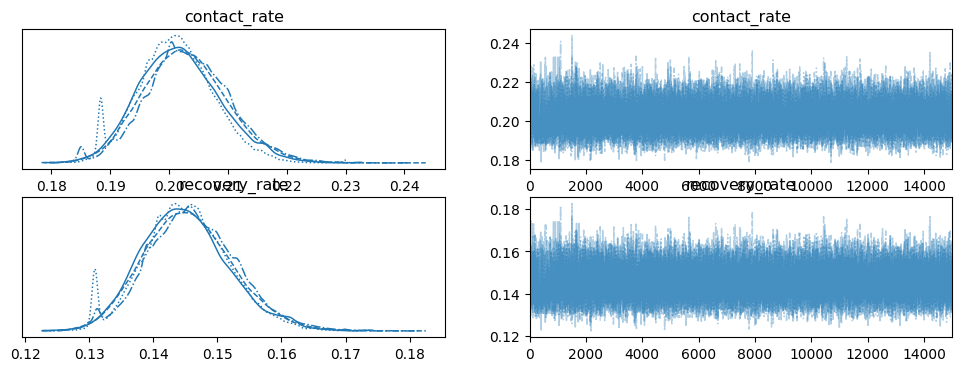

In [77]:
az.plot_trace(idata_smc)

In [ ]:
#Storing the results for later analysis

with open('./Results/Model_1/Multi_run_results_2.pkl', 'wb') as fp:
    pickle.dump(all_results, fp)


In [ ]:
len(results[results["Rhat_max"] > 1.1])

## Using arviz for trace visualization

In [ ]:
for idata, Run, draws, tune in zip(res.Trace, res.Run, res.Draws, res.Tune):
    subset = idata.sel(draw=slice(0, None), groups="posterior")
    print("Run = ",Run)
    az.plot_trace(subset, figsize=(16,3.2*len(subset.posterior)),compact=False)#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
    plt.show()



In [ ]:
#idata["sample_stats"]

In [ ]:
from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling import tools as esamptools

## Computing the likelihood function for each sampler

In [ ]:
from estival.model.base import ResultsData

In [ ]:
map_res : List[ResultsData]
targets_datas = pd.DataFrame(targets_data)

targets_datas.values

In [ ]:
#i=0 
#pd.options.plotting.backend = "matplotlib"
#map_res = np.zeros(8, dtype=ResultsData) #To specify the type of the elements in the list, default is tuple
map_res : List[ResultsData]
map_params = []
for idata, sampler ,run in zip(results_df.Trace, results_df.Sampler, results_df.Run):
    if (sampler == "metropolis"): #Because pm.metropolis is not compatible directly with the likelihood function from est.samp.tools
        # print(sampler)
       likelihood_df = esamptools.likelihood_extras_for_samples(idata.posterior, bcm_model_1)

    else :
        likelihood_df = likelihood_extras_for_idata(idata, bcm_model_1)
    ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
    map_parameter = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
    print(idata.posterior.to_dataframe().loc[ldf_sorted.index[0]])

    map_params.append(map_parameter)
    map_res.append(bcm_model_1.run(map_parameter))
    # res = bcm_model_1.run(map_parameter)
    # output = res.derived_outputs["active_cases"]

    # ax = pd.DataFrame(
    #     {
    #         f"{run}": output,
    #         "Observed" : targets_datas,
    #     }
    # ).plot(kind="scatter", x=targets_datas.index, y=targets_datas.values, labels=output_labels)
    # plt.show()
    #map_res[i] = bcm_model_1.run(map_parameter)
    #i+=1
        



In [ ]:
for res in zip (map_res):
    res

res[0].derived_outputs["active_cases"]

In [ ]:
dfs = []

for sampler, res, draws in zip(results_df.Sampler, map_res, results_df.Draws):
    res = res[0]
    ax = pd.DataFrame(
        {
            f"{sampler}, draws = {draws}": res.derived_outputs["active_cases"],
            "Observed" : targets_data,
        }
    ).plot(kind="scatter", labels=output_labels)
   
    
    plt.show()

#    comb_df = pd.concat(dfs, axis=1)

#    comb_df.plot(kind="scatter", labels=output_labels)
# comb_df

In [ ]:
# model_1.run(map_params)
"""
pd.DataFrame(
    {
        "DEMetropolisZ": map_res[0].derived_outputs["active_cases"],
        "DEMetropolis": map_res[1].derived_outputs["active_cases"],
        "Metropolis": map_res[2].derived_outputs["active_cases"],
        f"Metropolis, draws": map_res[3].derived_outputs["active_cases"],


        "observed": targets_data,
    }
).plot(kind="scatter", labels=output_labels)
"""


## Uncertainty sampling

In [ ]:
# Use the arviz extract method to obtain some samples, then convert to a DataFrame
sample_idata = az.extract(idata, num_samples=4000)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])


In [ ]:
# Wrapper function captures our bcm from the main namespace to pass into map_parallel
# Using this idiom in closures/factory functions is typical
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm_model_1.run(params)

# Run the samples through our BCM using the above function
# map_parallel takes a function and an iterable as input

# We use 4 workers here, default is cpu_count/2 (assumes hyperthreading)
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)


In [ ]:
sample_res

In [ ]:
# We'll use xarray for this step; aside from computing things very quickly, it's useful
# to persist the run results to netcdf/zarr etc

import xarray as xr

In [ ]:
# Build a DataArray out of our results, then assign coords for indexing
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]), 
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"], 
                          time=map_res[-1].derived_outputs.index, variable=map_res[-1].derived_outputs.columns)

In [ ]:
# Set some quantiles to calculate
quantiles = (0.25,0.5,0.75,0.80,0.95)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [ ]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

In [ ]:
variable = "active_cases"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res[-1].derived_outputs[variable]).plot(style='--')
bcm_model_1.targets[variable].data.plot(style='.',color="black", ms=5, alpha=0.8)

## Analysing the posterior likelihood landscape analysis using ELA

In [ ]:
# !pip install pflacco
from pflacco.classical_ela_features import *
from pflacco.local_optima_network_features import compute_local_optima_network, calculate_lon_features
#__To___create_a_initial____sample
from pflacco.sampling import create_initial_sample

# Application 2: The SEIR age-stratified model

## Data for fitting


In [ ]:
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting

df = pd.read_csv("./data/44000_incidence.csv")
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'].str.split(' - ').str[0])
df.index=df.date
targets_data = df.drop(columns='date')
#pivot_df = df.pivot(index='date', columns='incidence', values='incidence')
#pivot_df["total_cases"]=pivot_df.sum(1)



In [ ]:
#Truncate the data after 01/Febrary to only select Wuhan incident cases
targets_data_trunc = targets_data.loc[:'2020-01-31']

In [ ]:
parameters = {
    'incubation_period': 5.0,
    'infectious_period': 6.1,
    'age_transmission_rate_0': 0.3,
    'age_transmission_rate_15': 0.4,
    'age_transmission_rate_45': 0.8,
    'age_transmission_rate_65': 0.75

}

In [ ]:
#Names of parameters and their ranges
import estival.targets as est
import estival.priors as esp

params_range = [(0.0,1.0), (0.0,1.0),(0.0,1.0),(0.0,1.0) ]
params = {param: param_range for param,param_range in zip(parameters.keys(), params_range)}
priors = []
    
targets = [est.NormalTarget("incidence", targets_data_trunc['incidence'],
        esp.UniformPrior("incidence_dispersion",(0.1, targets_data_trunc["incidence"].max()*0.1)))] #Calibration de l'ecart type
       # 2000.0)] #Utiliser un nombre fixe pour ne pas l'inclure dans la calibration
normal_priors = [ 
       esp.TruncNormalPrior("incubation_period",5.4, 3.0, (1,15)),
       esp.TruncNormalPrior("infectious_period",7.3, 2.0, (1,15)),
      ]
uniform_priors = [
    esp.UniformPrior(transm_rates, (0.0,1.0)) for transm_rates in ["age_transmission_rate_0","age_transmission_rate_15","age_transmission_rate_45","age_transmission_rate_65"] 
]
priors = normal_priors + uniform_priors

## Model Definition


In [ ]:
model_2 = model2()

## Trial run

In [ ]:
model_2.run(parameters)

plot_start_date = datetime(2019, 12, 1)
analysis_end_date = datetime(2020, 3, 11)

plot = model_2.get_outputs_df().plot()
plot.update_xaxes(range=(plot_start_date, analysis_end_date))
plot.add_trace(go.Scatter(x=targets_data.index, y=targets_data_trunc["incidence"], mode='markers', name='data'))
#pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting
#pivot_df["total_cases"].plot.area()

## Calibration

In [ ]:
#Defining  a Bayesian Compartmental Model

bcm_model_2 = BayesianCompartmentalModel(model_2, parameters, priors, targets)
T = bcm_model_2.targets['incidence']
T.stdev

In [ ]:
##____Uniform Initialisation for each chain_________
chains = 8
init_vals = []
for c in range(chains):
    init_vals.append({param: np.random.uniform(0.0,1.0) for param in parameters.keys()})

In [ ]:
init_vals
pm.sample_smc

In [ ]:
res = cal.multirun(sampler = pm.DEMetropolisZ, 
            draws = 8000,
            tune = 1000,
            chains = 8,
            cores=chains,
            bcm_model = bcm_model_2,
            n_iterations = 1,
            n_jobs = 1,
            initial_params = None)

In [ ]:
idata = res["Trace"]
idata = idata[0]
az.rhat(idata)

In [ ]:
az.plot_trace(idata, figsize=(12,2.5*len(idata.posterior)),compact=False, legend=True)
plt.tight_layout(pad = 0.005)


In [ ]:
az.plot_posterior(idata)

In [ ]:
def fitting_test(idata, bcm):
    likelihood_df = likelihood_extras_for_samples(idata.posterior, bcm)
    # likelihood_df = likelihood_extras_for_idata(idata, bcm)
    ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

    # Extract the parameters from the calibration samples
    map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
    bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]
    # Run the model with these parameters
    map_res = bcm.run(map_params)
    # ...and plot some results
    
    return map_res

In [ ]:
map_res = fitting_test(idata, bcm_model_2)

In [ ]:
plot_start_date = datetime(2019, 12, 1)
analysis_end_date = datetime(2020, 3, 11)

plot = pd.DataFrame(map_res.derived_outputs["incidence"]).plot()
plot.update_xaxes(range=(plot_start_date, analysis_end_date))
plot.add_trace(go.Scatter(x=targets_data.index, y=targets_data_trunc["incidence"], mode='markers', name='data'))

In [ ]:
variable = "incidence"

pd.options.plotting.backend = "plotly"
pd.DataFrame(map_res.derived_outputs["incidence"]).plot(title = f"{variable} (MLE)")
pd.DataFrame(bcm_model_2.targets[variable].data).plot(style='.')